In [1]:
import numpy as np
import open3d as o3d
from open3d.web_visualizer import draw
from matplotlib import pyplot as plt
import imageio
import json
import os
os.environ["OPENCV_IO_ENABLE_OPENEXR"] = "1"
import cv2

def load_image(filename, is_depth=False):
    if is_depth:
        image = cv2.imread(filename, cv2.IMREAD_ANYDEPTH)
    else:
        image = cv2.imread(filename)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

pcd_path = "data/raw/point_clouds/ply_files/1024/anise/anise_001/pcd_1024.ply"
pcd_origin = o3d.io.read_point_cloud(pcd_path)

print(pcd_origin)

draw(pcd_origin)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[Open3D INFO] Resetting default logger to print to terminal.
PointCloud with 1024 points.
[Open3D INFO] Window window_0 created.
[Open3D INFO] EGL headless mode enabled.
[Open3D INFO] ICE servers: ["stun:stun.l.google.com:19302", "turn:user:password@34.69.27.100:3478", "turn:user:password@34.69.27.100:3478?transport=tcp"]
[Open3D INFO] Set WEBRTC_STUN_SERVER environment variable add a customized WebRTC STUN server.
[Open3D INFO] WebRTC Jupyter handshake mode enabled.
FEngine (64 bits) created at 0x7f931f442010 (threading is enabled)
EGL(1.5)
OpenGL(4.1)


WebVisualizer(window_uid='window_0')

[Open3D INFO] Sending init frames to window_0.


In [2]:
def load_focal(basedir):
    with open(os.path.join(basedir, 'transforms.json'), 'r') as fp:
        meta = json.load(fp)
    camera_angle_x = float(meta['camera_angle_x'])
    
    for frame in meta['frames']:
        fname = os.path.join(basedir, 'images', frame['file_path'].split('/')[-1] + '.png')
        img = imageio.imread(fname)[..., :3]
        H, W = img.shape[:2]
        break
    
    focal = .5 * W / np.tan(.5 * camera_angle_x)
    return [H, W, focal]

In [3]:
def load_pose(basedir, idx):
    with open(os.path.join(basedir, 'transforms.json'), 'r') as fp:
        meta = json.load(fp)
    frame = meta['frames'][idx]
    pose = np.array(frame['transform_matrix'])
    pose[:, 1:3] *= -1
    return pose

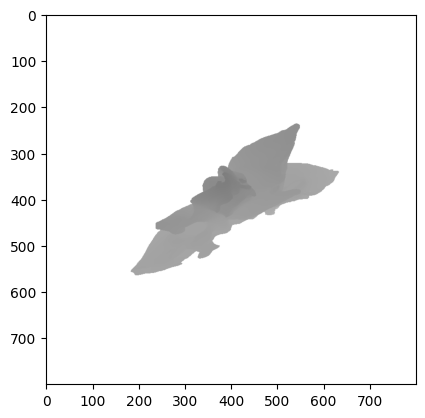

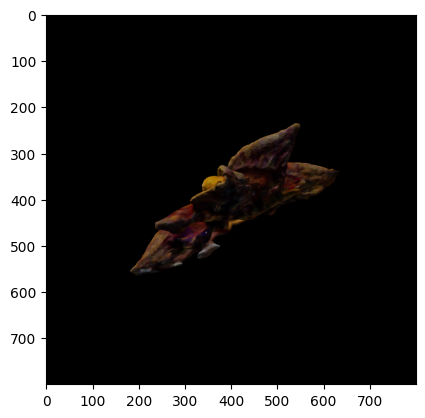

[3102:695][1699450] (dtls_transport.cc:529): DtlsTransport[0|1|__]: OnWritableState() called in state DTLS_TRANSPORT_CLOSED.


In [33]:
basedir = "data/raw/blender_renders/anise/anise_001/render"
depth_path = os.path.join(basedir, "depths/r_0_depth.exr")
depth = cv2.imread(depth_path, -1)
# depth[depth==65535] = np.nan
depth = depth / 65535
scale = 0.04974293762001597
depth = depth / scale
rgb = load_image(os.path.join(basedir, "images/r_0.png"))
plt.imshow((depth * 500).clip(0, 1))
plt.figure()
plt.imshow(rgb)

In [23]:
H, W, focal = load_focal(basedir)
print(H, W, focal)
cam_intr = np.array([[focal, 0, H/2], [0, focal, W/2], [0, 0, 1]])
print(cam_intr)
pose = load_pose(basedir, 0)
print(pose)

800 800 1111.1110311937682
[[1.11111103e+03 0.00000000e+00 4.00000000e+02]
 [0.00000000e+00 1.11111103e+03 4.00000000e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
[[-4.44208622e-01 -6.72430634e-01  5.92043757e-01 -2.38660479e+00]
 [-8.95923376e-01  3.33398461e-01 -2.93541789e-01  1.18330479e+00]
 [ 1.49011612e-08 -6.60819590e-01 -7.50544727e-01  3.02554250e+00]
 [ 0.00000000e+00 -0.00000000e+00 -0.00000000e+00  1.00000000e+00]]


/tmp/ipykernel_1699084/3123005507.py:8: DeprecationWarning:

Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.



In [24]:
def get_pcd_from_rgbd(depth_normalized, rgb_img, cam_intr_mat, cam_extr_mat):
    depth_o3d = o3d.geometry.Image(np.ascontiguousarray(depth).astype(np.float32))
    rgb_o3d = o3d.geometry.Image(np.ascontiguousarray(rgb_img).astype(np.uint8))
    rgbd_o3d = o3d.geometry.RGBDImage.create_from_color_and_depth(
        rgb_o3d, depth_o3d, depth_scale=1, convert_rgb_to_intensity=False
    )

    cam_intr = o3d.camera.PinholeCameraIntrinsic(
        width=depth_normalized.shape[1],
        height=depth_normalized.shape[0],
        fx=cam_intr_mat[0, 0],
        fy=cam_intr_mat[1, 1],
        cx=cam_intr_mat[0, 2],
        cy=cam_intr_mat[1, 2],
    )
    cam_extr = np.array(cam_extr_mat)

    pcd = o3d.geometry.PointCloud.create_from_rgbd_image(
        rgbd_o3d,
        cam_intr,
        cam_extr,
    )

    return pcd


In [25]:
pcd = get_pcd_from_rgbd(depth, rgb, cam_intr, pose)
# draw(pcd.points)

In [26]:

import plotly.graph_objects as go

def plot_point_cloud(pts, **kwargs):
    return go.Scatter3d(x=pts[:, 0], y=pts[:, 1], z=pts[:, 2], mode="markers", **kwargs)

figure = go.Figure(
    data=[
        plot_point_cloud(
            np.asarray(pcd.points)[::4],
            marker={"color": np.array(pcd.colors)[::4], "size": 3},
        ),
        plot_point_cloud(
            np.asarray(pcd_origin.points),
            marker={"color": "red", "size": 3},
        )
    ]
)
figure.update_layout(scene=dict(aspectmode="data", aspectratio=dict(x=1, y=1, z=1)))
figure.show()
